## PyToch Dataset Class 정의

In [2]:
from torch.utils.data import Dataset
from PIL import Image
import os

class CustomSegmentationDataset(Dataset):
    def __init__(self, images_folder, masks_folder, feature_extractor):
        self.images_folder = images_folder
        self.masks_folder = masks_folder
        self.feature_extractor = feature_extractor
        self.image_files = sorted(os.listdir(images_folder))
        self.mask_files = sorted(os.listdir(masks_folder))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_folder, self.image_files[idx])
        mask_path = os.path.join(self.masks_folder, self.mask_files[idx])

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path)

        inputs = self.feature_extractor(images=image, segmentation_maps=mask, return_tensors="pt")
        return {
            'pixel_values': inputs['pixel_values'].squeeze(),
            'labels': inputs['labels'].squeeze()
        }


## pre-trained segformer model load

In [3]:
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor

# 사전 학습된 SegFormer 모델과 피처 추출기 로드
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b4-finetuned-ade-512-512")
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b4-finetuned-ade-512-512")


ModuleNotFoundError: No module named 'transformers'

## 학습용 PyTorch Lightning 모듈 정의

In [3]:
import pytorch_lightning as pl
import torch

class SegformerFineTuner(pl.LightningModule):
    def __init__(self, model):
        super(SegformerFineTuner, self).__init__()
        self.model = model

    def forward(self, pixel_values, labels):
        outputs = self.model(pixel_values=pixel_values, labels=labels)
        return outputs.loss, outputs.logits

    def training_step(self, batch, batch_idx):
        pixel_values, labels = batch['pixel_values'], batch['labels']
        loss, logits = self(pixel_values, labels)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        pixel_values, labels = batch['pixel_values'], batch['labels']
        loss, logits = self(pixel_values, labels)
        self.log("val_loss", loss)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=5e-5)


## 데이터 로더 설정

In [5]:
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor

# SegFormer 모델 로드 및 새로운 클래스 수 설정
total_classes = 150 + 1  # ADE20K의 150개 클래스 + 새로 추가된 클래스
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b4-finetuned-ade-512-512", 
    num_labels=total_classes, 
    ignore_mismatched_sizes=True  # 크기 불일치 무시
)
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b4-finetuned-ade-512-512")


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b4-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([151, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([151]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are no

In [14]:
import os
from PIL import Image
import torch
from torch.utils.data import DataLoader  # DataLoader 임포트 추가
import numpy as np
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

In [15]:
# 로컬 데이터셋 경로 설정
train_images_folder = "fine_tuning_data/data/train/image"  # 훈련 이미지가 저장된 경로
train_masks_folder = "fine_tuning_data/data/train/label"    # 훈련 마스크가 저장된 경로
val_images_folder = "fine_tuning_data/data/valid/image"      # 검증 이미지가 저장된 경로
val_masks_folder = "fine_tuning_data/data/valid/label"        # 검증 마스크가 저장된 경로

# 데이터셋 로드
train_dataset = CustomSegmentationDataset(images_folder=train_images_folder, masks_folder=train_masks_folder, feature_extractor=feature_extractor)
val_dataset = CustomSegmentationDataset(images_folder=val_images_folder, masks_folder=val_masks_folder, feature_extractor=feature_extractor)

# DataLoader 설정
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4)


In [16]:
import pytorch_lightning as pl
import torch

class SegformerFineTuner(pl.LightningModule):
    def __init__(self, model):
        super(SegformerFineTuner, self).__init__()
        self.model = model

    def forward(self, pixel_values, labels):
        outputs = self.model(pixel_values=pixel_values, labels=labels)
        return outputs.loss, outputs.logits

    def training_step(self, batch, batch_idx):
        pixel_values, labels = batch['pixel_values'], batch['labels']
        loss, logits = self(pixel_values, labels)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        pixel_values, labels = batch['pixel_values'], batch['labels']
        loss, logits = self(pixel_values, labels)
        self.log("val_loss", loss)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=5e-5)


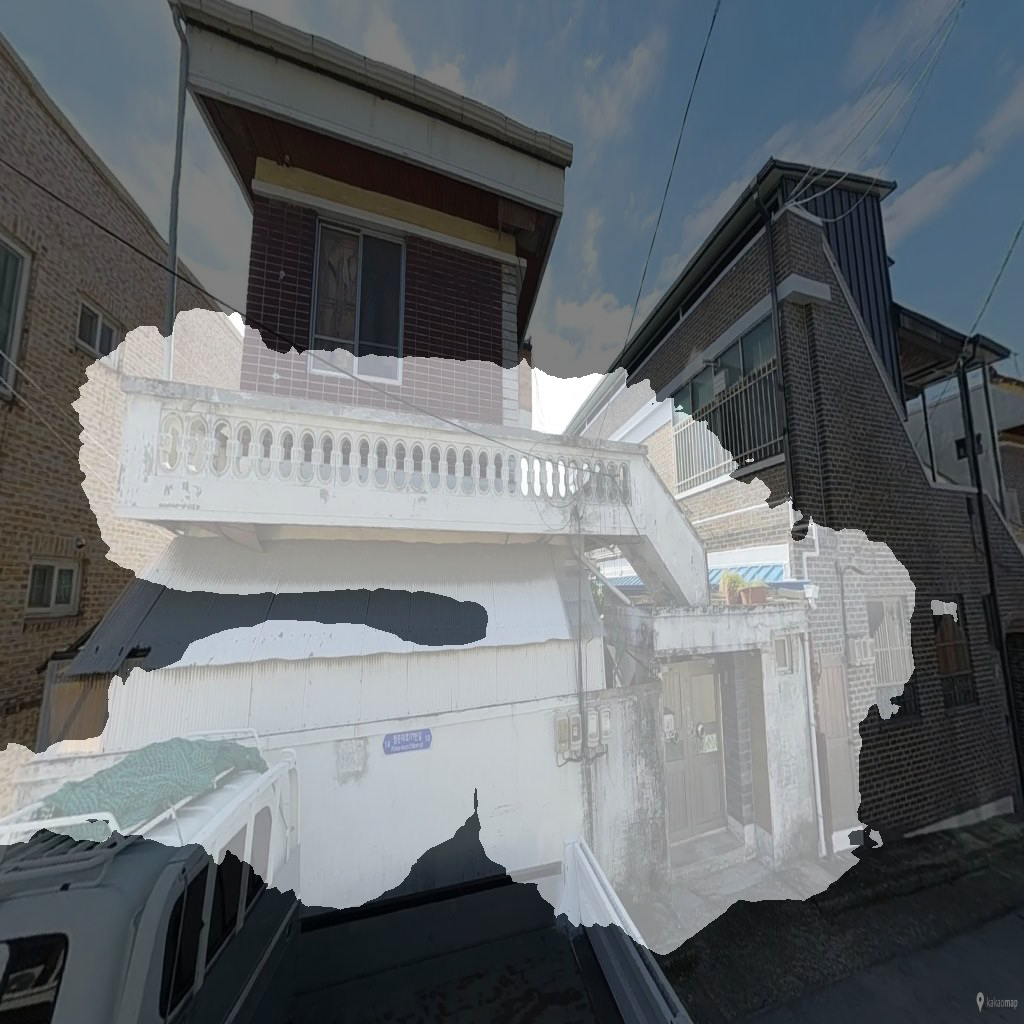

In [20]:
import os
from PIL import Image
import torch
import numpy as np
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

# SegFormer 모델과 피처 추출기 로드
finetuned_model = SegformerForSemanticSegmentation.from_pretrained("finetuned_segformer")
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b4-finetuned-ade-512-512")

# 색상 맵 (객체를 흰색으로 표시)
color_map = {
    0: [0, 0, 0],      # 배경 (검은색)
    1: [255, 255, 255] # 객체 (흰색)
}

# 이미지 전처리 함수
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")
    return inputs, image

# 분할 결과 시각화 함수 (반투명 오버레이)
def visualize_segmentation_overlay(image, segmentation, color_map, alpha=0.5):
    height, width = segmentation.shape
    segmented_image = np.zeros((height, width, 3), dtype=np.uint8)

    # segmentation 값을 color_map에 따라 색상 할당
    for class_id, color in color_map.items():
        segmented_image[segmentation == class_id] = color

    segmented_image_pil = Image.fromarray(segmented_image)

    # 원본 이미지와 분할된 이미지를 혼합 (alpha 값으로 투명도 조절)
    blended_image = Image.blend(image.convert("RGB"), segmented_image_pil.convert("RGB"), alpha=alpha)

    return blended_image

# 추론 예시
inputs, image = preprocess_image("fine_tuning_data/data/test/image/5_png.rf.b7f2b598dfb918f1c1870e57941ed4eb.jpg")
with torch.no_grad():
    outputs = finetuned_model(pixel_values=inputs['pixel_values'])

logits = outputs.logits
upsampled_logits = torch.nn.functional.interpolate(logits, size=(image.size[1], image.size[0]), mode='bilinear', align_corners=False)
predicted_segmentation = upsampled_logits.argmax(dim=1)[0].cpu().numpy()

# 결과 시각화
blended_image = visualize_segmentation_overlay(image, predicted_segmentation, color_map)
blended_image.show()
